In [1]:
import sys
sys.path.append('../')

import tquant as tq


import tensorflow as tf
from datastore import *
import matplotlib.pyplot as plt
import QuantLib as ql

def get_ql_curve(curve_tq, evaluation_date):
    evaluation_date_ql = ql.Date.from_date(evaluation_date)
    dates_ql = [evaluation_date_ql + d for d in curve_tq._pillar_days]
    rates_ql = [r.numpy() for r in curve_tq._rates]
    curve_ql = ql.ZeroCurve(dates_ql, rates_ql, ql.ActualActual(ql.ActualActual.ISDA), ql.TARGET())
    curve_ql.enableExtrapolation()
    return curve_ql


# Settings

In [2]:
tq.Settings.evaluation_date = date(2024, 4, 30)

calendar = tq.TARGET()
daycounter = tq.DayCounter(tq.DayCounterConvention.Actual360)
evaluation_date = tq.Settings.evaluation_date

rates = ir_eur_curve_estr['quote'].values
times = ir_eur_curve_estr['daycount'].values/365


rate_curve = tq.RateCurve(evaluation_date, times, rates, 'LINEAR')
eur6m_index = tq.IborIndex(calendar, 6, tq.TimeUnit.Months, tq.Currency.EUR)

# Hull and White

In [3]:
a = 0.03
sigma = 0.2
#TQ
hw_tq = tq.HullWhiteProcess(rate_curve, a, sigma)
time_grid = np.linspace(start=0.0, stop=10, num=60, retstep=False)
kernel = tq.GaussianPathGenerator(hw_tq, time_grid)

short_rate = kernel.simulate(n_paths=10000)
short_rate_df = pd.DataFrame(short_rate).T

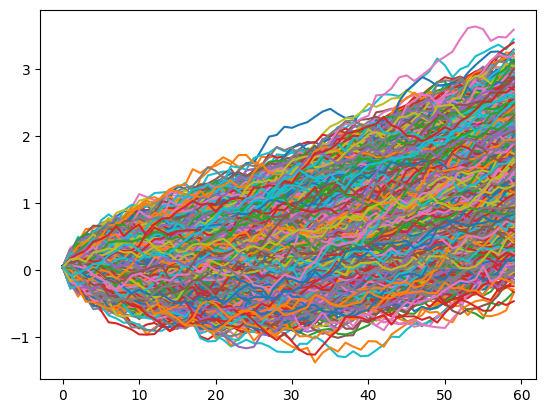

In [4]:
plt.plot(short_rate_df)
plt.show()

In [12]:
# creazione curve future zcb 
# pricing swap a date future

## QL

In [5]:
# QL
rate_curve_ql = get_ql_curve(rate_curve, evaluation_date)
hrate_curve_ql = ql.YieldTermStructureHandle(rate_curve_ql)
hw_ql = ql.HullWhiteProcess(hrate_curve_ql, a, sigma)

timestep_len= len(time_grid[1:])
dimension = hw_ql.factors()
Npaths = 10000
gen_paths = np.zeros((dimension, timestep_len+1, Npaths))

rng = ql.UniformRandomSequenceGenerator(dimension * timestep_len, ql.UniformRandomGenerator())
sequenceGenerator = ql.GaussianRandomSequenceGenerator(rng)
pathGenerator = ql.GaussianMultiPathGenerator(hw_ql, list(time_grid), sequenceGenerator, False)

for i in range(Npaths):
    samplePath = pathGenerator.next()
    values = samplePath.value() 

    for j in range(dimension):
        gen_paths[j, :, i] = values[0]

In [6]:
short_rate_df_ql =  pd.DataFrame(gen_paths[0,:,:])

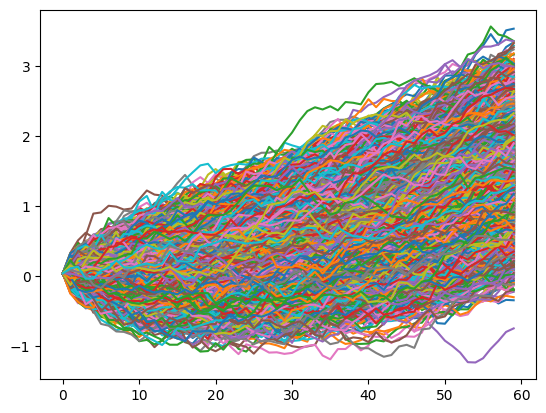

In [10]:
plt.plot(short_rate_df_ql)
plt.show()

In [13]:
# test curve future zcb vs ql
# pricing swap a date future

# OLD

In [ ]:
hw = tq.HullWhiteProcess(a, sigma, rate_curve)
hw_kernel = tq.GaussianRateKernel1D(hw)

# simulate short rate and discount curve 
paths = int(1e6) 
r_tensor, zb_tensor, grid = hw_kernel.rate_tensor(paths,
                                                  last_grid_time=1,
                                                  time_steps=2) 
# Reshape the tensor and create a discount curve object
reshaped_tensor = tf.reshape(zb_tensor, shape=(zb_tensor.shape[1], paths, 1))
rate_curve_tensor = tq.RateCurve.from_zcb(evaluation_date, times, reshaped_tensor, "LINEAR")

In [ ]:
rate_curve_tensor.discount(2.0)